In [1]:
import scvelo as scv
import cellrank as cr
import scanpy as scp
import pickle
import numpy as np
from os.path import exists
import collections
import warnings
import random
random.seed(42)
warnings.filterwarnings('ignore')

In [2]:
adata = scv.read("all.h5ad")

In [3]:
adata = adata[adata.obs['sample'].isin(['N1KO D14','N1KO D30','WT D14','WT D30'])]
adata

View of AnnData object with n_obs × n_vars = 6997 × 36601
    obs: 'orig.ident', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced', 'nCount_ambiguous', 'nFeature_ambiguous', 'nCount_RNA', 'nFeature_RNA', 'orig.ident.1', 'nCount_RNA.1', 'nFeature_RNA.1', 'percent.ribo', 'percent.mito', 'count.mad.lower', 'count.mad.higher', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.2', 'seurat_clusters', 'cell_type', 'condition', 'sample'
    var: 'features', 'unspliced_features'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [4]:
#R: sample_color <- as.character(glasbey.colors()[-1])
#R: cell_type_color <- as.character(palette36.colors(36)[-2])
sample_color=  {
    'WT D0': '#0000FF',
    'WT D2': '#FF0000',
    'WT D5': '#00FF00',
    'WT D10': '#000033',
    'WT D14': '#FF00B6',
    'WT D30': '#005300',
    'N1KO D0': '#FFD300',
    'N1KO D2': '#009FFF',
    'N1KO D5': '#9A4D42',
    'N1KO D10': '#00FFBE',
    'N1KO D14': '#783FC1',
    'N1KO D30': '#1F9698'
}

cell_type_color=  {
    'Atrial cardiomyocyte' : '#5A5156',
    'Cardiac fibroblast' : '#F6222E',
    'Cardiac mesoderm' : '#FE00FA',
    'Differentiating iPSC' : '#16FF32',
    'Early cardiomyocyte' : '#3283FE',
    'Epicardial progenitor' : '#FEAF16',
    'FHF progenitor' : '#B00068',
    'iPSC' : '#1CFFCE',
    'Mesoderm' : '#90AD1C',
    'Pacemaker cell' : '#2ED9FF',
    'SHF progenitor' : '#DEA0FD',
    'Unidentified' : '#AA0DFE',
    'Vascular smooth muscle cell' : '#F8A19F',
    'Ventricular cardiomyocyte' : '#325A9B'

}

cell_types=adata.obs['cell_type'].unique()
color_dict={ ct.replace(u' ', u'\xa0'): cell_type_color[ct.replace(u' ', u'\xa0')] for ct in cell_types }
ordered_color_dict = collections.OrderedDict(sorted(color_dict.items()))
this_cell_type_color = list(ordered_color_dict.values())

samples=adata.obs['sample'].unique()
sample_dict={ sample: sample_color[sample] for sample in samples }
ordered_sample_dict = collections.OrderedDict(sorted(sample_dict.items()))
this_sample_color = list(ordered_sample_dict.values())

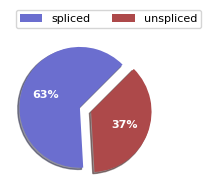

In [5]:
scv.pl.proportions(adata)

In [6]:
scv.pp.neighbors(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=20, n_neighbors=30)
scv.tl.velocity(adata)
scv.tl.velocity_graph(adata)
scv.tl.recover_dynamics(adata)
scv.tl.latent_time(adata)
scv.tl.velocity_pseudotime(adata)
scv.tl.diffmap(adata)
scv.tl.umap(adata)

computing neighbors
    finished (0:00:08) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
Filtered out 22334 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
recovering dynamics (using 1/40 cores)


  0%|          | 0/430 [00:00<?, ?gene/s]

    finished (0:05:01) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


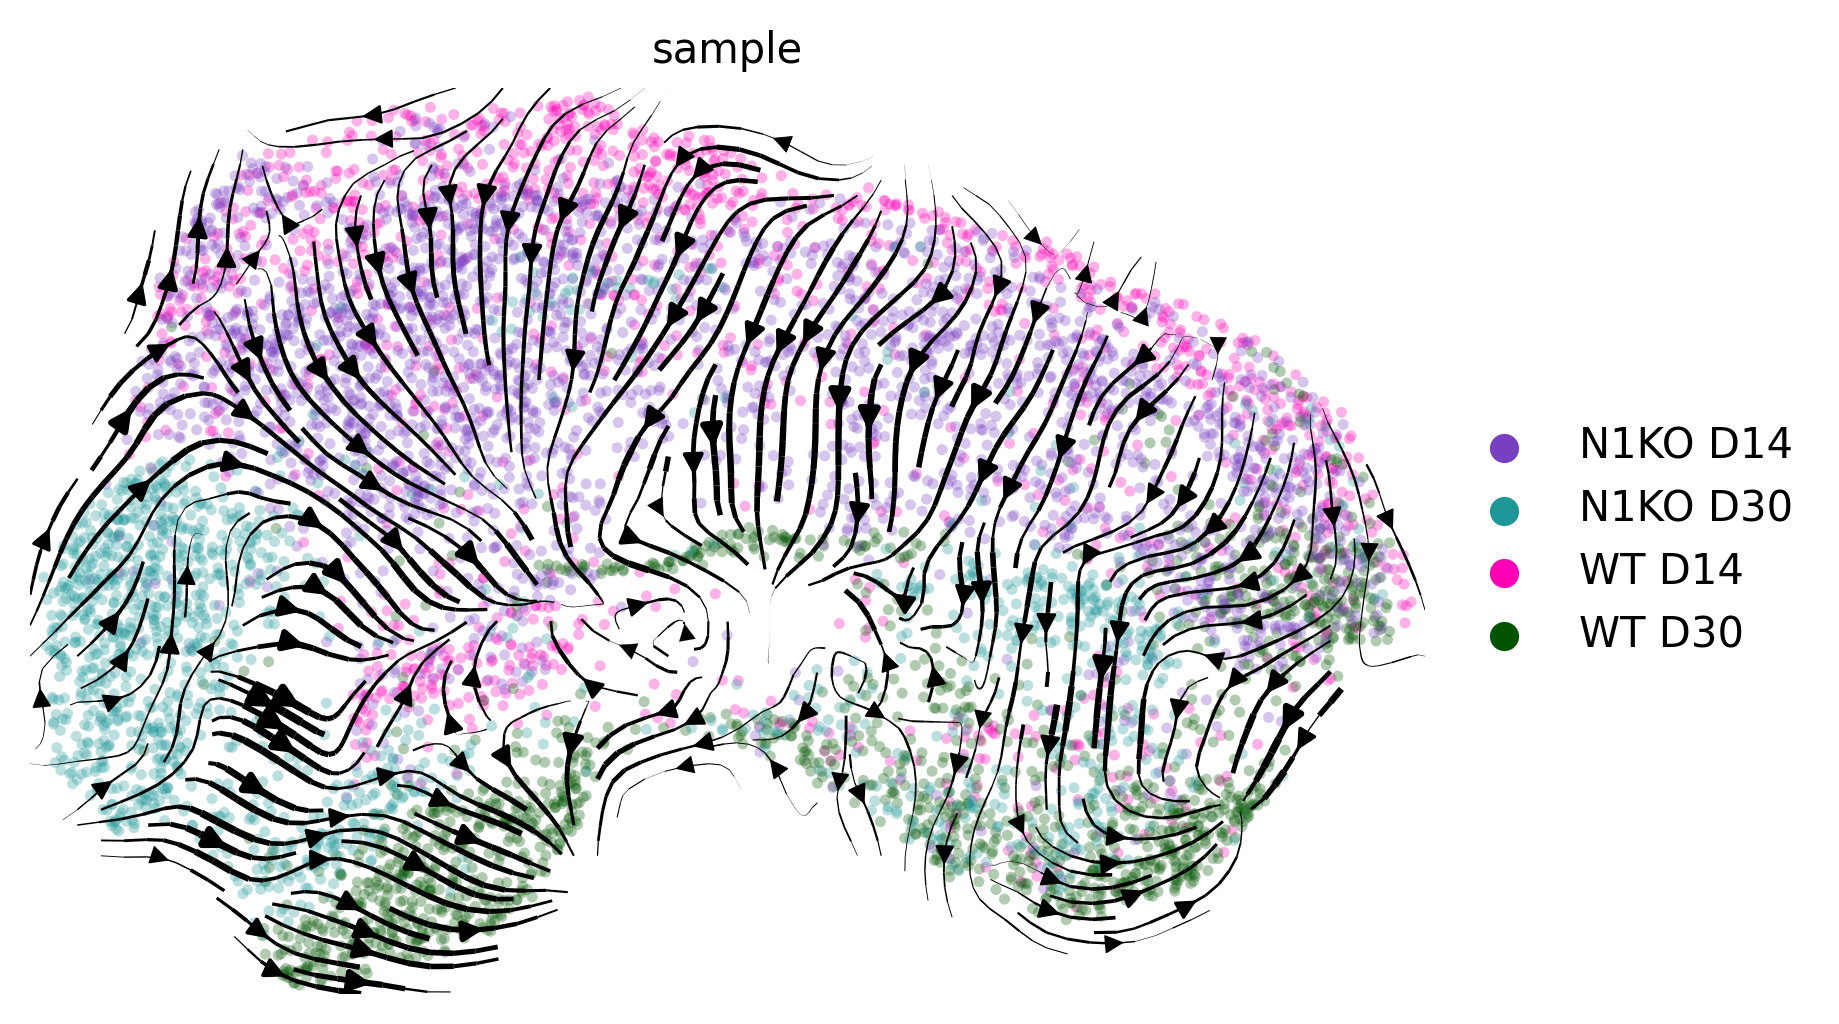

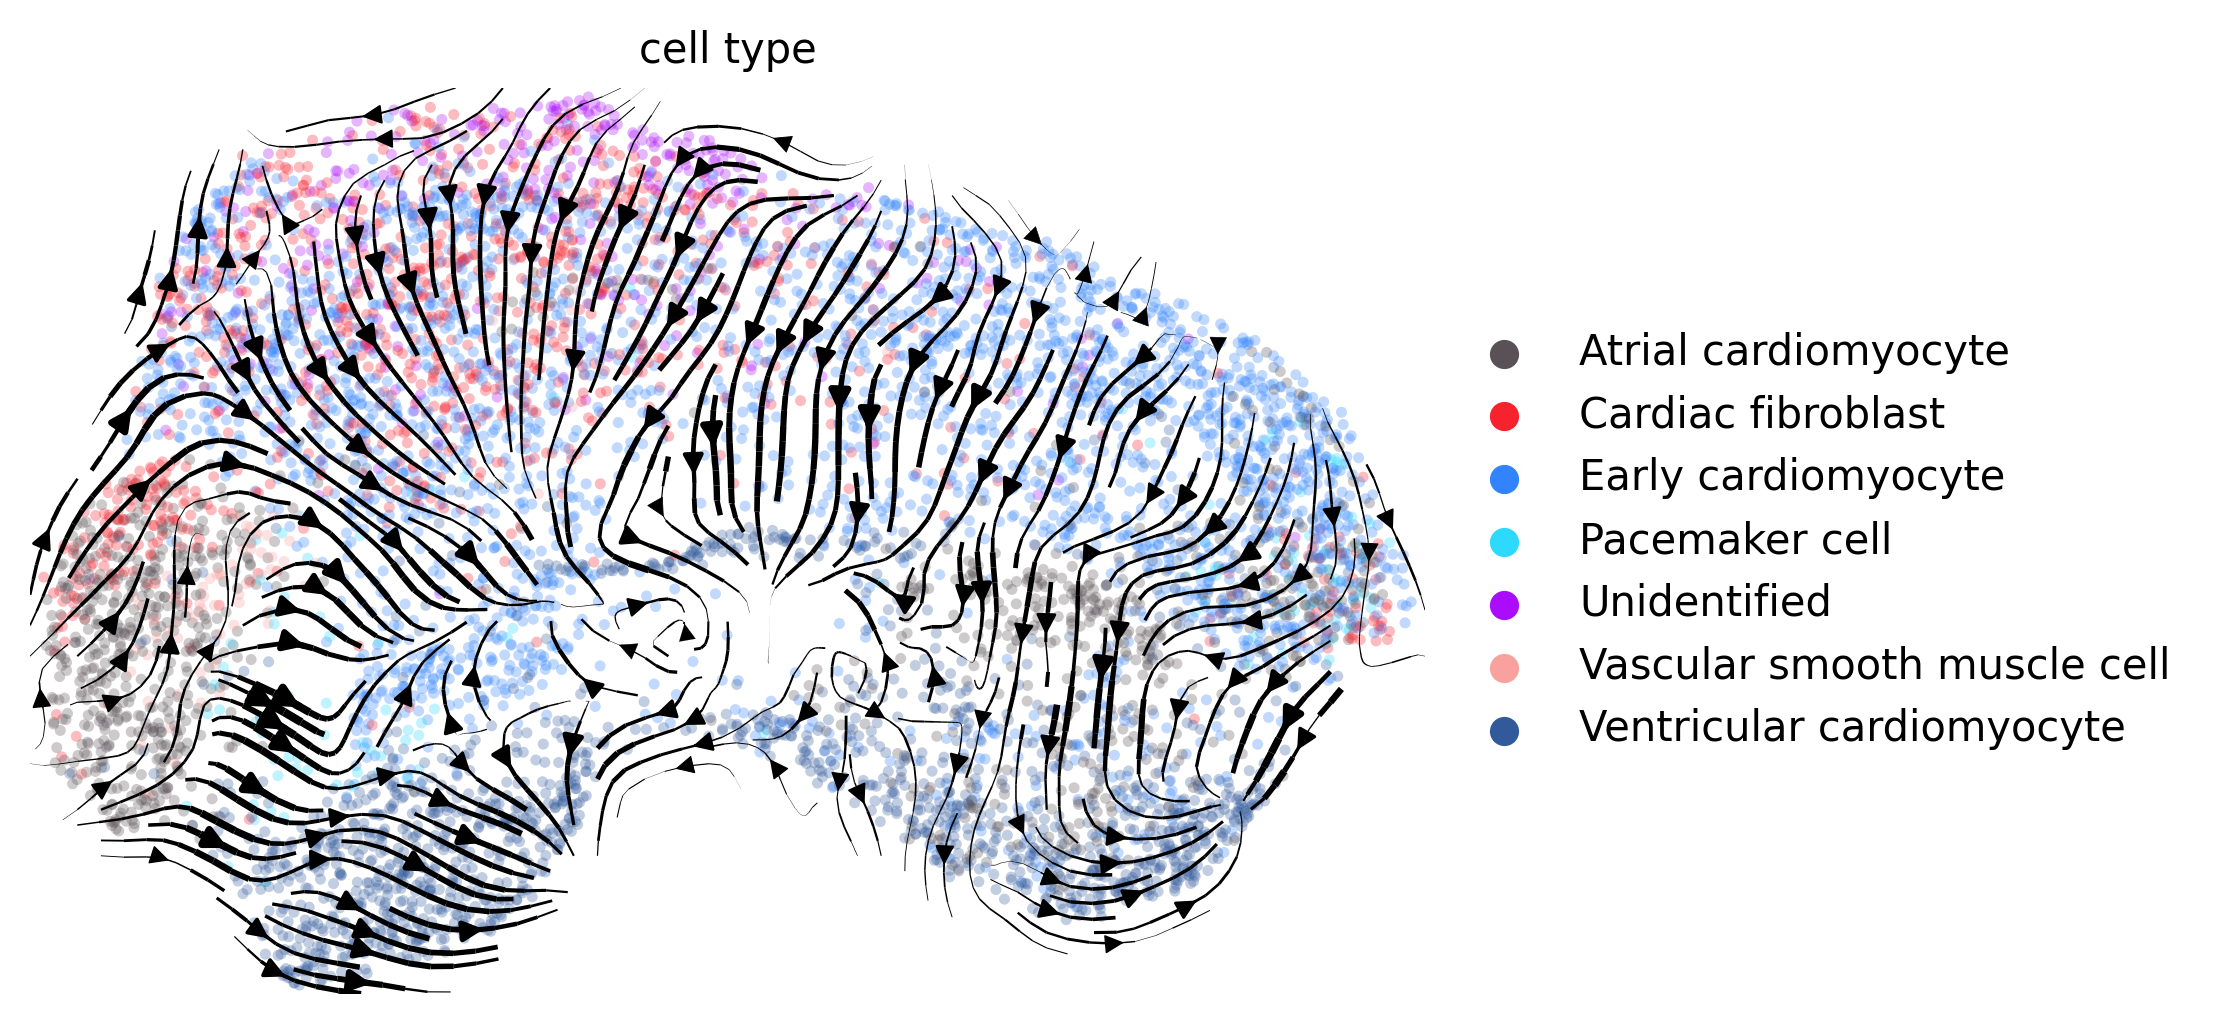

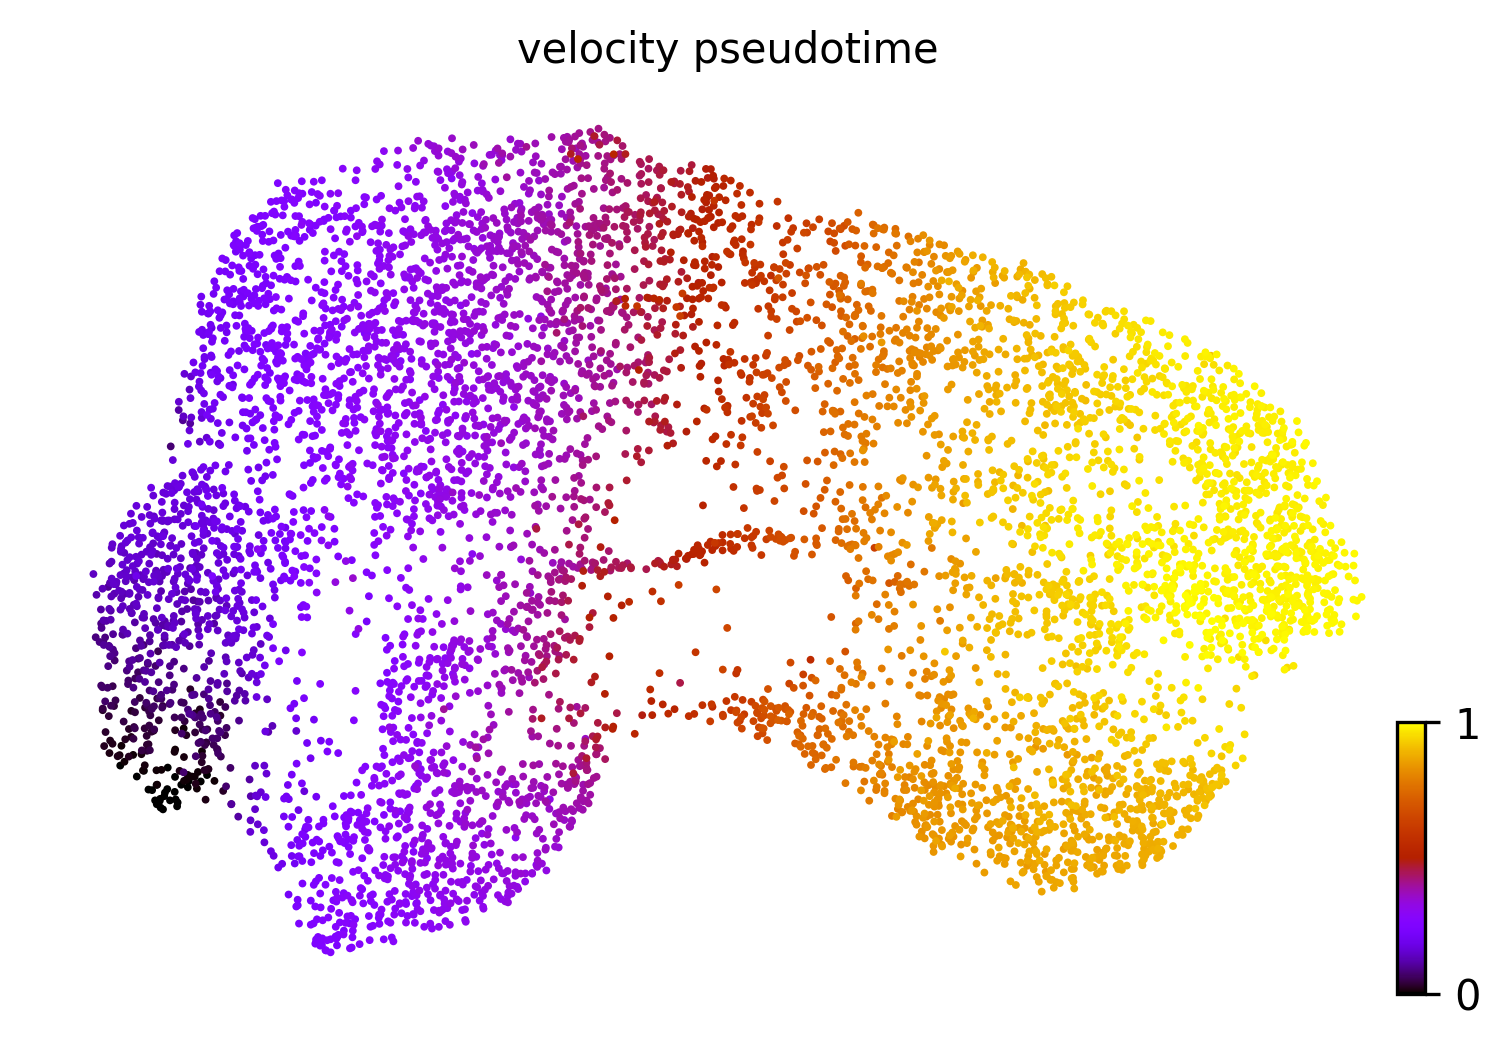

In [7]:
scv.pl.velocity_embedding_stream(adata, basis="umap", color="sample",palette=this_sample_color,size=28, dpi=300, legend_loc='right margin') 
scv.pl.velocity_embedding_stream(adata, basis="umap", color="cell_type",palette=this_cell_type_color,size=28, dpi=300, legend_loc='right margin')
scv.pl.scatter(adata, basis='umap', color='velocity_pseudotime', cmap='gnuplot', dpi=300, size=14, legend_loc='right margin')

### Important genes from velocity

In [8]:
scv.tl.rank_velocity_genes(adata, groupby='cell_type', min_corr=.3)
df = scv.DataFrame(adata.uns['rank_velocity_genes']['names'])
df.head(30)

ranking velocity genes
    finished (0:00:03) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


,Atrial cardiomyocyte,Cardiac fibroblast,Early cardiomyocyte,Pacemaker cell,Unidentified,Vascular smooth muscle cell,Ventricular cardiomyocyte
0,PCDH10,BNC2,TECRL,SRRM4,ADGRV1,PDLIM3,MLIP
1,CCDC80,CPED1,COL6A2,PDLIM3,SLIT1,CDKN2A,TTN
2,CALD1,ROBO2,RPS6KA5,ATXN1,CDH6,PCDH10,LAMA2
3,CDKN2A,ITGA8,WT1,DMD,NEBL,NEAT1,RBM20
4,MYL7,CCDC3,ROBO2,PCDH10,AL358613.1,ATXN1,CTNNA3
5,ANXA1,PRTG,CHRM2,XRCC4,COL2A1,ANXA1,SLC8A1
6,GUCY1A2,GPC3,CCBE1,DGKI,PRTG,FHL1,PLCL1
7,CNN1,PLAT,CACNA1D,MYOCD,ALPL,FHOD3,FGF12
8,SAT1,RPS6KA5,PODXL,TTK,CRABP1,GUCY1A2,FHOD3
9,FN1,MIS18BP1,C7,FANCD2,ERBB4,DMD,TRDN-AS1
